In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np


# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                #user = user.lower() #try with this test
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

#date to date format and sorting with it

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['user', 'date'])

# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'total_messages': total_messages_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)

stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')

#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
subData =  subData[~subData['message'].str.contains(' converted from ', case=False, na=False)]

gifterData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)].copy()
gifterData['gifts'] = gifterData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))

gift_per_stream_2 = gifterData.groupby('stream')['gifts'].sum()

stream_stats = pd.merge(stream_stats, gift_per_stream_2, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'gifts': 'gift2'})
stream_stats['gift2'] = stream_stats['gift2'].fillna(0)

giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

stream_stats['gift'] = np.maximum(stream_stats['gift'], stream_stats['gift2'])

primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]

tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)

# Extract only the date (without time)
data['date_only'] = data['date'].dt.date

# Group by 'stream' and find the first message date
stream_date = data.groupby('stream')['date_only'].min().reset_index()

# Rename the columns appropriately
stream_date.columns = ['stream', 'stream_date']

# Merge the stream_date with the stream_stats DataFrame
stream_stats = stream_stats.merge(stream_date, on='stream', how='left')

# Convert stream_date to datetime if it is not already
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.004

#stream point
stream_stats['stream_points'] = (
    stream_stats['tier1'] * 1 +
    stream_stats['tier2'] * 2 +
    stream_stats['tier3'] * 6
)



In [2]:
stream_stats.tail(2)

,stream,total_messages,stream_length,stream_length_hour,avg,max,follow,games,one_message_user_count,hours_watched,...,message_per_min,gift2,gift,prime,tier1,tier2,tier3,stream_date,ad_rev,stream_points
564,564,13107,24485.0,6.801389,834,1022,92,"jc, re9",322,5672.358333,...,32.118440,24.0,24.0,13.0,15.0,0.0,0.0,2026-02-27,22.689433,15.0
565,565,9714,18378.0,5.105000,872,1009,95,"jc, re9",275,4451.560000,...,31.714006,7.0,7.0,14.0,20.0,0.0,2.0,2026-02-28,17.806240,32.0


In [3]:
# Convert stream_date to datetime format
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Create a Year-Month column
stream_stats['year_month'] = stream_stats['stream_date'].dt.to_period('M')

In [4]:
# Group by Year-Month and sum the required numeric columns
monthly_data = stream_stats.groupby('year_month')[['prime', 'tier1', 'tier2', 'tier3','gift','ad_rev']].sum().reset_index()
monthly_data.set_index('year_month', inplace=True)
monthly_data['avg'] = stream_stats.groupby('year_month')['avg'].mean()
monthly_data.reset_index(inplace=True)
monthly_data['PartnerPlus'] = (
    stream_stats.groupby('year_month')['stream_points'].sum()
    .reindex(monthly_data['year_month'])  # Align to existing 'year_month'
    .values  # Use only the values for assignment
)



In [5]:
monthly_avg2 = stream_stats.groupby('year_month').apply(
    lambda x: (x['avg'] * x['stream_length_hour']).sum() / x['stream_length_hour'].sum()
).reset_index(name='avg2')

# Merge avg2 back into the original dataframe
monthly_data = monthly_data.merge(monthly_avg2, on='year_month', how='left')

C:\Users\Kardo\AppData\Local\Temp\ipykernel_12372\337569208.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_avg2 = stream_stats.groupby('year_month').apply(


In [6]:
monthly_hours_avg_correct = stream_stats.groupby('year_month')['stream_length_hour'].mean().reset_index(name='avg_stream_length')

# Merge hours_avg back into the original dataframe
monthly_data = monthly_data.merge(monthly_hours_avg_correct, on='year_month', how='left')


In [7]:
monthly_hours = stream_stats.groupby('year_month').apply(
    lambda x: (x['stream_length_hour']).sum()
).reset_index(name='hours')

# Merge avg2 back into the original dataframe
monthly_data = monthly_data.merge(monthly_hours, on='year_month', how='left')

C:\Users\Kardo\AppData\Local\Temp\ipykernel_12372\1560455463.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_hours = stream_stats.groupby('year_month').apply(


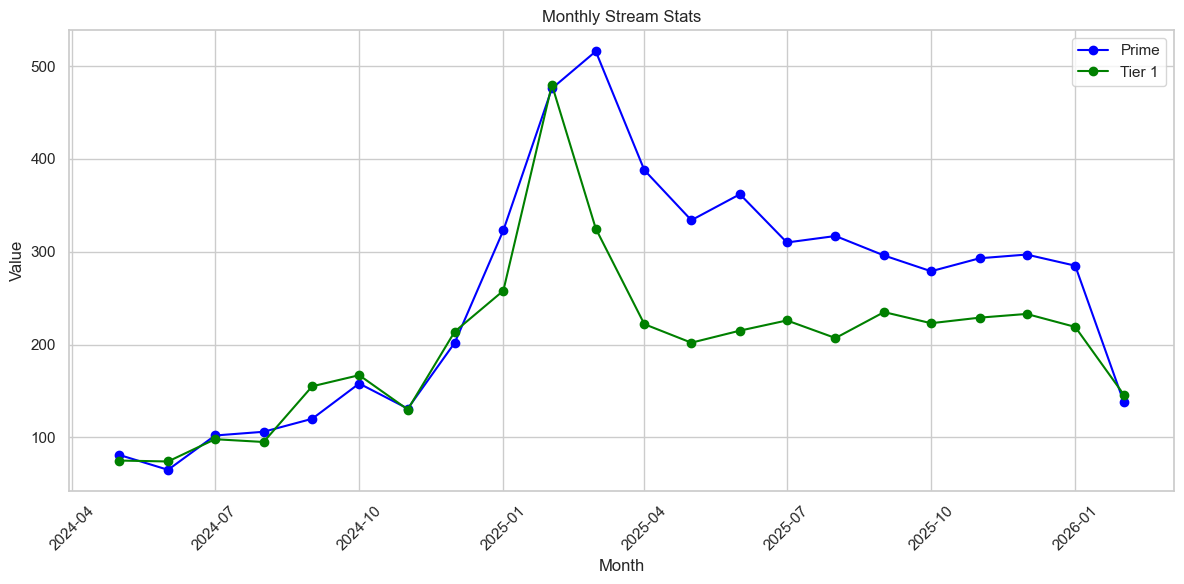

In [8]:
# Convert year_month to datetime for plotting
monthly_data['year_month'] = monthly_data['year_month'].dt.to_timestamp()

# Set the style for the plot
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each column separately with a different color
plt.plot(monthly_data['year_month'], monthly_data['prime'], marker='o', label='Prime', color='blue')
plt.plot(monthly_data['year_month'], monthly_data['tier1'], marker='o', label='Tier 1', color='green')

# Adding titles and labels
plt.title('Monthly Stream Stats')
plt.xlabel('Month')
plt.ylabel('Value')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

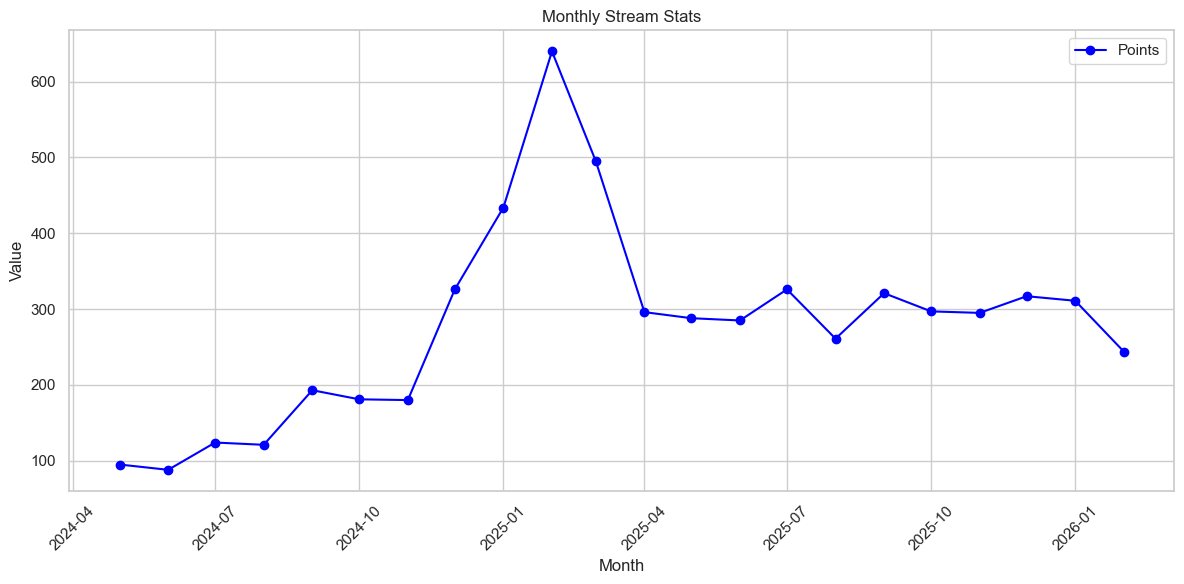

In [9]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each column separately with a different color
plt.plot(monthly_data['year_month'], monthly_data['PartnerPlus'], marker='o', label='Points', color='blue')

# Adding titles and labels
plt.title('Monthly Stream Stats')
plt.xlabel('Month')
plt.ylabel('Value')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

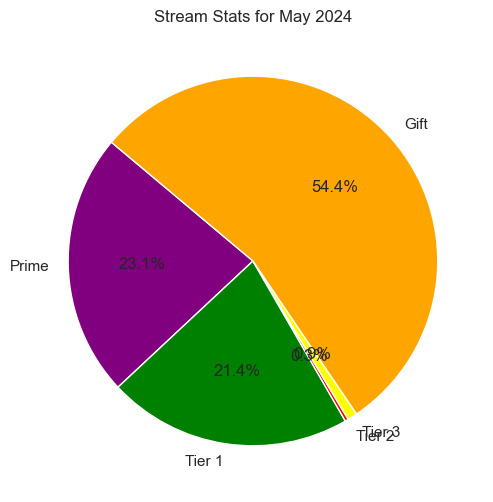

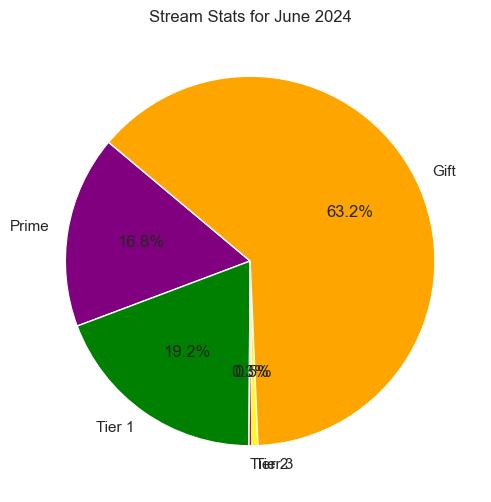

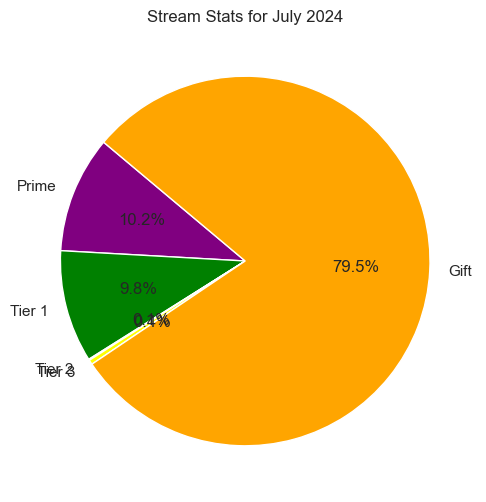

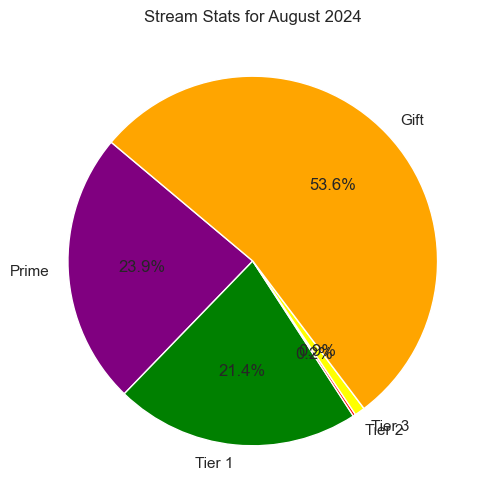

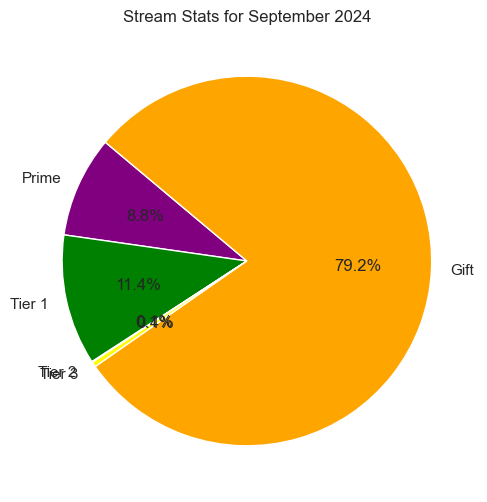

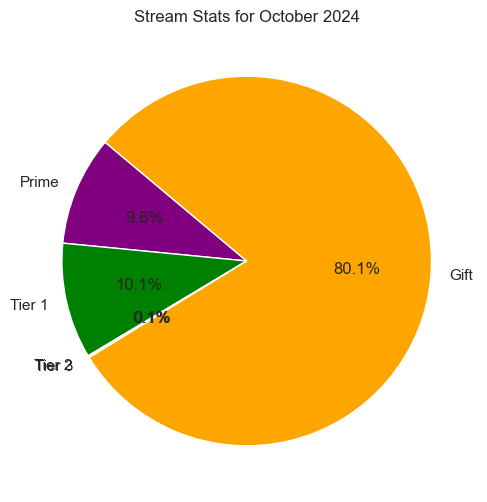

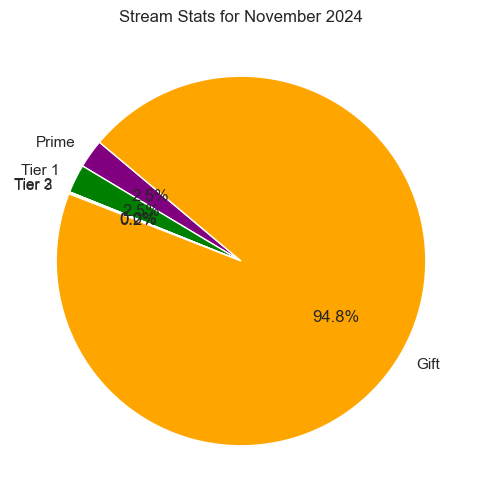

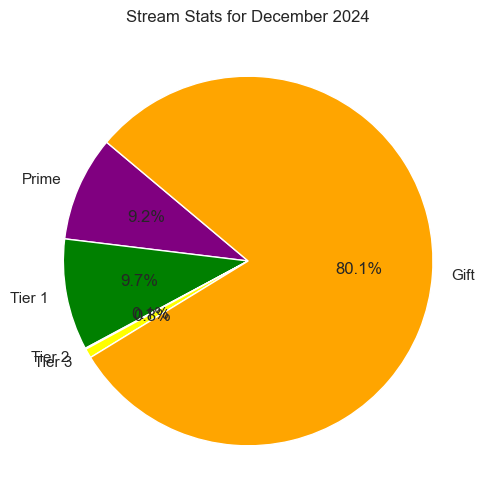

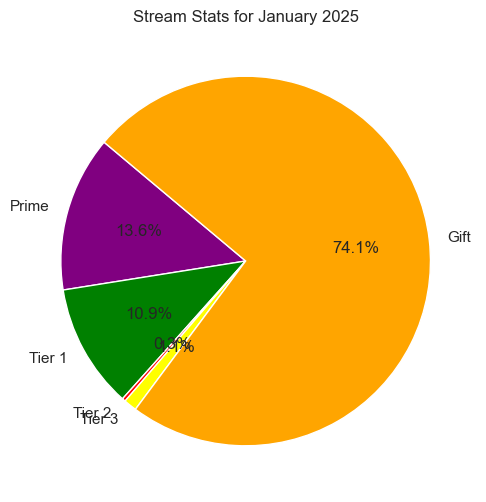

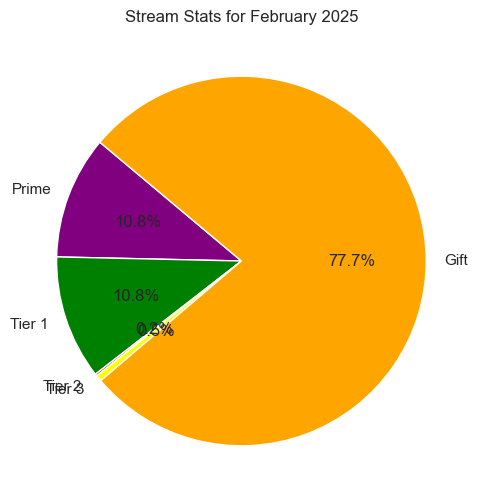

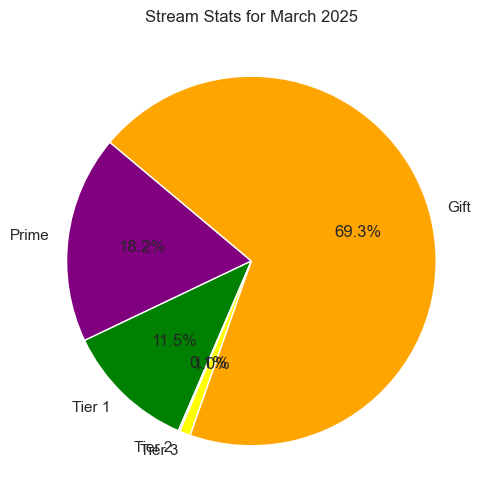

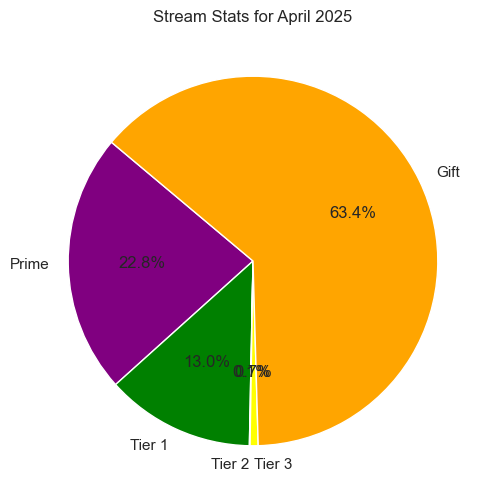

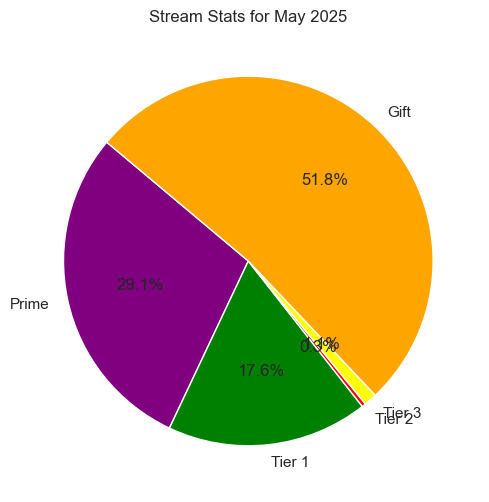

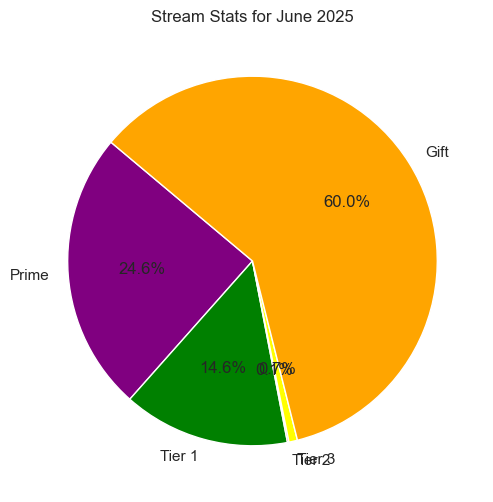

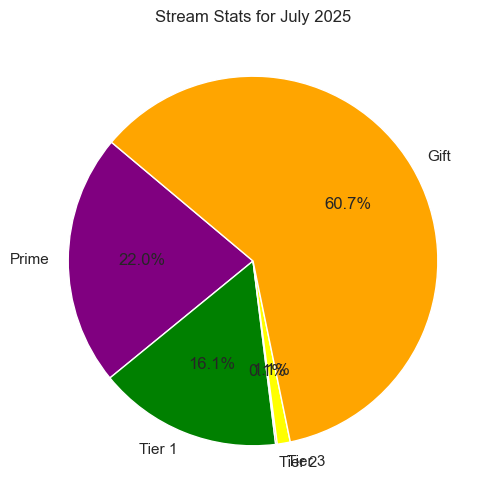

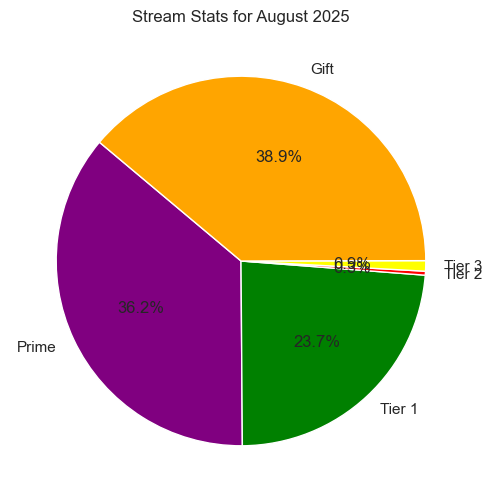

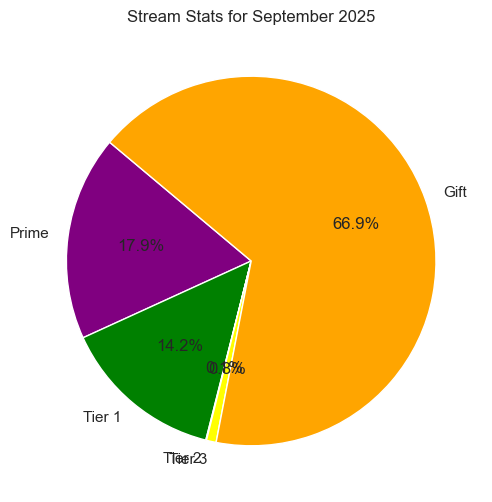

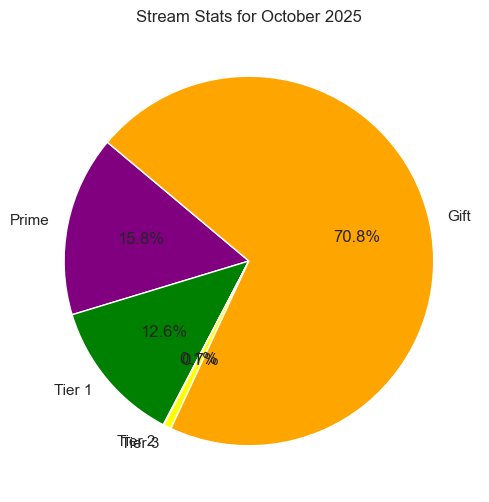

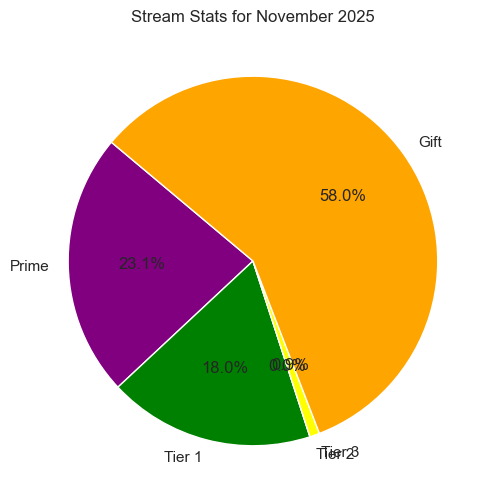

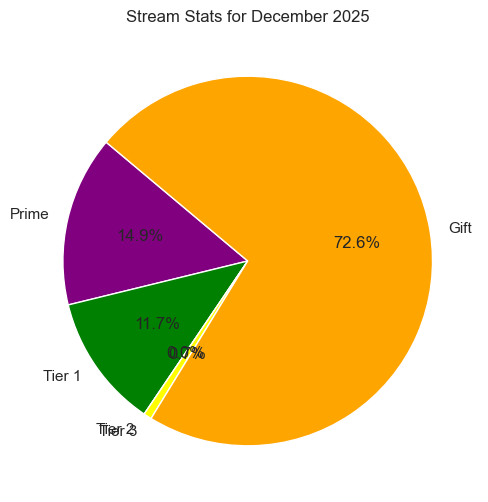

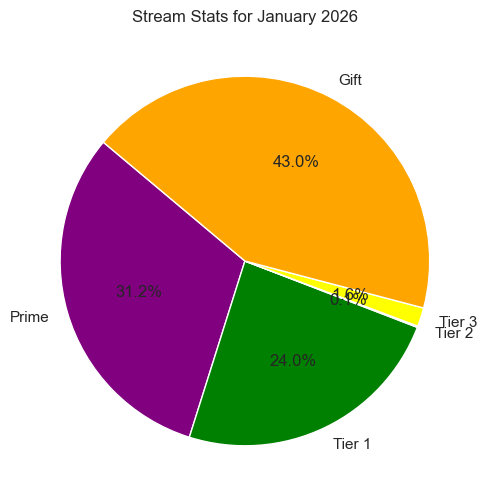

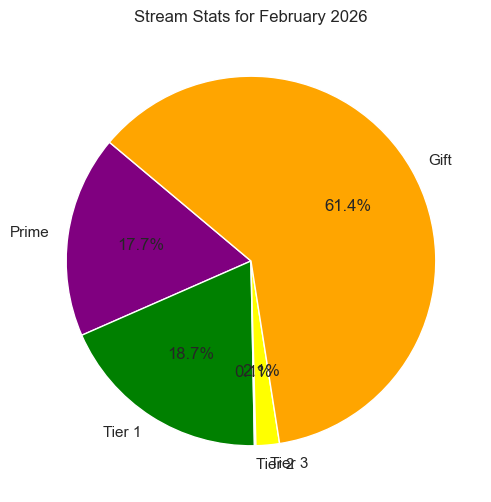

In [10]:
# Iterate through each row in the DataFrame to create a pie chart for each month
for index, row in monthly_data.iterrows():
    # Extract data for the current month
    labels = ['Prime', 'Tier 1', 'Tier 2', 'Tier 3', 'Gift']
    sizes = [row['prime'], row['tier1'], row['tier2'], row['tier3'], row['gift']]
    
    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['purple','green', 'red', 'yellow', 'orange'])
    
    # Title the chart with the corresponding month
    plt.title(f"Stream Stats for {row['year_month'].strftime('%B %Y')}")
    
    # Display the plot
    plt.show()

In [11]:
#monthly_data.to_csv('month_data_output.csv', index=False)

In [12]:
monthly_data['sub_rev'] = monthly_data['prime'] * 1.4 + monthly_data['tier1'] * 1.4 + monthly_data['tier2'] * 2.8 + monthly_data['tier3'] * 5 + monthly_data['gift'] * 1.4
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus,avg2,avg_stream_length,hours,sub_rev
0,2024-05-01,81.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0,165.904994,5.124521,148.611111,503.6
1,2024-06-01,65.0,74.0,1.0,2.0,244.0,99.460279,205.956522,88.0,216.289572,4.998345,114.961944,549.0
2,2024-07-01,102.0,98.0,1.0,4.0,793.0,118.660999,208.777778,124.0,209.680514,5.239938,141.478333,1413.0
3,2024-08-01,106.0,95.0,1.0,4.0,238.0,115.630142,241.380952,121.0,243.267993,5.658571,118.830000,637.4
4,2024-09-01,120.0,155.0,1.0,6.0,1074.0,177.910924,274.615385,193.0,273.719408,6.249765,162.493889,1921.4
5,2024-10-01,158.0,167.0,1.0,2.0,1323.0,186.066281,344.384615,181.0,349.268660,5.122415,133.182778,2320.0
6,2024-11-01,131.0,130.0,1.0,8.0,4937.0,200.659684,404.041667,180.0,416.701199,5.016076,120.385833,7320.0
7,2024-12-01,202.0,214.0,2.0,18.0,1760.0,283.674678,494.074074,326.0,500.949108,5.243282,141.568611,3142.0
8,2025-01-01,323.0,258.0,7.0,27.0,1756.0,369.612638,738.076923,434.0,729.220372,4.873654,126.715000,3426.4
9,2025-02-01,476.0,480.0,8.0,24.0,3436.0,1030.490901,2216.916667,640.0,2175.591988,4.933958,118.415000,6291.2


In [13]:
monthly_data["PartnerPlusOther"] = [128, 146, 160, 185, 246, 271, 288, 409, 694, 783, 728, 592, 555, 533, 551, 525, 514, 510, 515, 536, 551, 447]
monthly_data
#https://twitch-tools.rootonline.de/plusPoints_stats.php?channel_id=634606699

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus,avg2,avg_stream_length,hours,sub_rev,PartnerPlusOther
0,2024-05-01,81.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0,165.904994,5.124521,148.611111,503.6,128
1,2024-06-01,65.0,74.0,1.0,2.0,244.0,99.460279,205.956522,88.0,216.289572,4.998345,114.961944,549.0,146
2,2024-07-01,102.0,98.0,1.0,4.0,793.0,118.660999,208.777778,124.0,209.680514,5.239938,141.478333,1413.0,160
3,2024-08-01,106.0,95.0,1.0,4.0,238.0,115.630142,241.380952,121.0,243.267993,5.658571,118.830000,637.4,185
4,2024-09-01,120.0,155.0,1.0,6.0,1074.0,177.910924,274.615385,193.0,273.719408,6.249765,162.493889,1921.4,246
5,2024-10-01,158.0,167.0,1.0,2.0,1323.0,186.066281,344.384615,181.0,349.268660,5.122415,133.182778,2320.0,271
6,2024-11-01,131.0,130.0,1.0,8.0,4937.0,200.659684,404.041667,180.0,416.701199,5.016076,120.385833,7320.0,288
7,2024-12-01,202.0,214.0,2.0,18.0,1760.0,283.674678,494.074074,326.0,500.949108,5.243282,141.568611,3142.0,409
8,2025-01-01,323.0,258.0,7.0,27.0,1756.0,369.612638,738.076923,434.0,729.220372,4.873654,126.715000,3426.4,694
9,2025-02-01,476.0,480.0,8.0,24.0,3436.0,1030.490901,2216.916667,640.0,2175.591988,4.933958,118.415000,6291.2,783


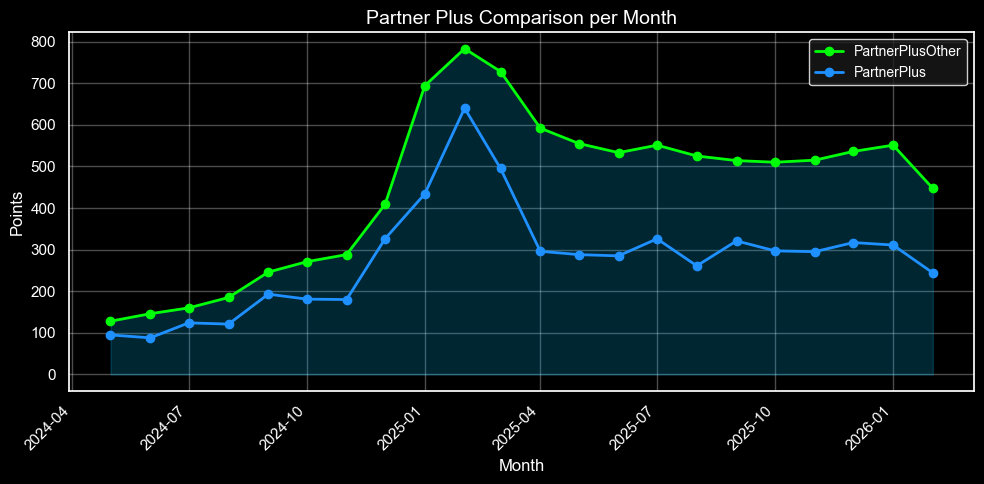

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Example setup: assuming you already have your monthly_data DataFrame
# and that it includes a 'Month' column.
# monthly_data = pd.read_csv("monthly_data.csv")

plt.style.use("dark_background")  # dark mode like your image

fig, ax = plt.subplots(figsize=(10, 5))

# Plot both lines
ax.plot(monthly_data["year_month"], monthly_data["PartnerPlusOther"], 
        label="PartnerPlusOther", color="#00FF08", marker="o", linewidth=2)
ax.plot(monthly_data["year_month"], monthly_data["PartnerPlus"], 
        label="PartnerPlus", color="#1E90FF", marker="o", linewidth=2)

# Fill area under the bigger one (optional for a nicer look)
ax.fill_between(monthly_data["year_month"], monthly_data["PartnerPlusOther"], color="#00BFFF", alpha=0.2)

# Labels and title
ax.set_title("Partner Plus Comparison per Month", fontsize=14, color="white")
ax.set_xlabel("Month", color="white")
ax.set_ylabel("Points", color="white")

# Grid and legend
ax.grid(alpha=0.3)
ax.legend(facecolor="#1a1a1a", edgecolor="white", fontsize=10)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [15]:
monthly_data["PartnerPlusError"] = (
    abs(monthly_data["PartnerPlusOther"] - monthly_data["PartnerPlus"])
    / monthly_data["PartnerPlus"].replace(0, np.nan)
) * 100

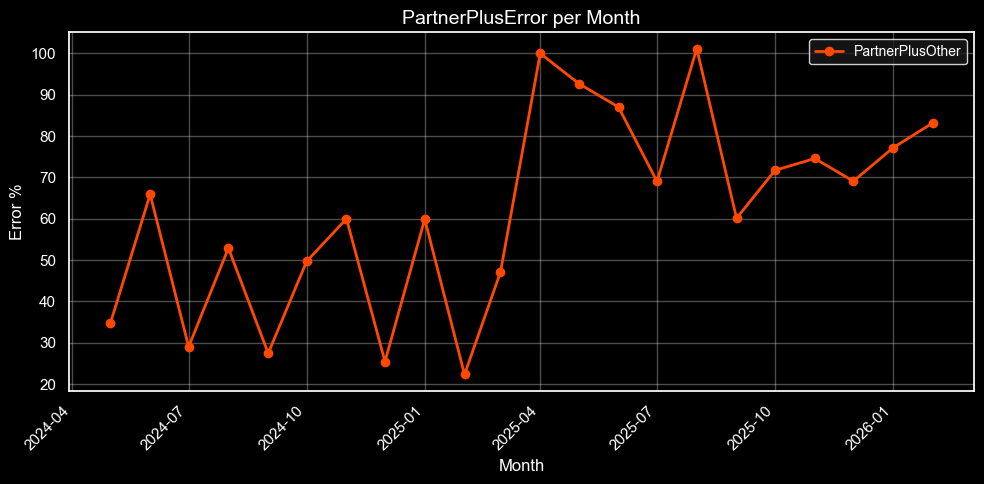

In [16]:
plt.style.use("dark_background")  # dark mode like your image
fig, ax = plt.subplots(figsize=(10, 5))

# Plot both lines
ax.plot(monthly_data["year_month"], monthly_data["PartnerPlusError"], 
        label="PartnerPlusOther", color="#FF4800", marker="o", linewidth=2)

# Labels and title
ax.set_title("PartnerPlusError per Month", fontsize=14, color="white")
ax.set_xlabel("Month", color="white")
ax.set_ylabel("Error %", color="white")

# Grid and legend
ax.grid(alpha=0.3)
ax.legend(facecolor="#1a1a1a", edgecolor="white", fontsize=10)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [17]:
monthly_data["SumIncome"] = (monthly_data["sub_rev"] + monthly_data["ad_rev"] + (( monthly_data["PartnerPlusOther"]-monthly_data["PartnerPlus"])* 1.4)).round(0).astype(int)


In [18]:
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus,avg2,avg_stream_length,hours,sub_rev,PartnerPlusOther,PartnerPlusError,SumIncome
0,2024-05-01,81.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0,165.904994,5.124521,148.611111,503.6,128,34.736842,648
1,2024-06-01,65.0,74.0,1.0,2.0,244.0,99.460279,205.956522,88.0,216.289572,4.998345,114.961944,549.0,146,65.909091,730
2,2024-07-01,102.0,98.0,1.0,4.0,793.0,118.660999,208.777778,124.0,209.680514,5.239938,141.478333,1413.0,160,29.032258,1582
3,2024-08-01,106.0,95.0,1.0,4.0,238.0,115.630142,241.380952,121.0,243.267993,5.658571,118.830000,637.4,185,52.892562,843
4,2024-09-01,120.0,155.0,1.0,6.0,1074.0,177.910924,274.615385,193.0,273.719408,6.249765,162.493889,1921.4,246,27.461140,2174
5,2024-10-01,158.0,167.0,1.0,2.0,1323.0,186.066281,344.384615,181.0,349.268660,5.122415,133.182778,2320.0,271,49.723757,2632
6,2024-11-01,131.0,130.0,1.0,8.0,4937.0,200.659684,404.041667,180.0,416.701199,5.016076,120.385833,7320.0,288,60.000000,7672
7,2024-12-01,202.0,214.0,2.0,18.0,1760.0,283.674678,494.074074,326.0,500.949108,5.243282,141.568611,3142.0,409,25.460123,3542
8,2025-01-01,323.0,258.0,7.0,27.0,1756.0,369.612638,738.076923,434.0,729.220372,4.873654,126.715000,3426.4,694,59.907834,4160
9,2025-02-01,476.0,480.0,8.0,24.0,3436.0,1030.490901,2216.916667,640.0,2175.591988,4.933958,118.415000,6291.2,783,22.343750,7522


In [19]:
#monthly_data.to_csv('month_data_output.csv', index=False)